# How to run the pipeline on a set of imager data and create and subtract a sky background

If you have a set of imager data without extended sources such as a nebula or extended galaxy structure, you can create a mean (or median) background image from the data itself and subtract it off after the level two imaging pipeline stage is run to remove any remaining structure from imperfect flat fields or other issues. MIRI images have higher backgrounds at longer wavelengths, so this will be more useful for longer wavelength images, but can be used for any filter, so long as there is no extended source. 

This example notebook will demonstrate how to process a data set through the stage one and two imager pipelines, then use the cal.fits files to create the background sky and subtract it from each of the individual science images. Once you have the background subtracted images, the different dithers are then combined into a single image in the level 3 imaging pipeline.

The code used for the creation and subtraction of the background sky image was created by Karl Gordon and can be found separately on this github page: https://github.com/STScI-MIRI/Imaging_ExampleNB

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code and install directions are available on GitHub: https://github.com/spacetelescope/jwst

The steps in this notebook are:


  1)  Read in list of uncalibrated data (uncal.fits) files.

  2)  Process through calwebb_detector1.

  3)  Process ramp fit (rate.fits) files through calwebb_image2.
    
  4)  Create and remove a mean sky background from each calibrated (cal.fits) image.

  5)  Create an assocation file for the calibrated files.

  6)  Run the calibrated files through calwebb_image3 using the association file.
    
Setup needed before getting started.

* Place notebook and data into the directory where you wish to process your data.

* Install pipeline (and pip install any missing modules you encounter when you try to run).


### Caveats: This method of creating a background to subtract from the data should only be used in fields without extended sources such as galaxy or nebula emission that stretches across the image. It also will not work well with only a couple of dithers. The more dithers you have, the better this will work. Please examine your data before and after, and examine the output sky image to determine whether this does or does not work for your data specifically.

This notebook was written in July 2023, and was meant to work with pipeline version 1.11.1. Future versions of the pipeline should work, but backward compatibility of notebooks is not guaranteed with all python package updates.

## Information on Running the pipeline

This notebook utilizes the .call() method of running the notebook in python. With this method, the pipeline will retrieve and use any parameter reference file that applies to your data. These files will set certain parts of the code to run or be skipped, or select any parameters that the instrument teams have put as preferred defaults for most science cases. If you run with this method and do not set any custom parameters, you will replicate what you would get from the automated pipeline and populated in MAST. 

If you wish to customize the parameters, you can read the documentation in the ReadTheDocs link posted above. Each step in the pipeline has a section in the documentation that explains the parameters relevant to that step.  To set the parameters, a configuration dictionary is set up (and shown in the notebook as examples), then that custom configuration overrides the default values that would have come from the parameter reference files.

Most parameters that would need customization come in the stage three pipeline, but the jump step in the first pipeline stage, calwebb_detector1, also has a more extensive set of customizable parameters, and reading the documentation for this step could prove useful.

In order to run the pipeline and retrieve the necessary reference files from CRDS, there are a couple of CRDS variables that need to be set. CRDS_PATH tells the pipeline where to save and retrieve reference files. This should be set to a local directory where new reference files will be downloaded, and frequently used reference files can be retrieved and used without needing to pull large files across your internet connection. The other path that needs to be set is the CRDS_SERVER_URL, to know where to look to retrieve any new reference files. That path should be set to https://jwst-crds-stsci.edu. In this notebook, these are set using the os.environ statements below.

NOTE: you should store only CRDS reference files in your CRDS cache directory. This is in case you need to delete and redo your CRDS cache area at any point, and you don't want to chance erasing anything that should not be deleted.

os.environ['CRDS_PATH'] = '/local_crds_path/crds_cache_ops/'

os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds-stsci.edu'

### Using datamodels

This notebook will show how to use datamodels in working with your data. 
The basic steps involve reading a file into a datamodel type and then opening the individual named extensions as needed.

Header data is stored in the .meta extension.

Science data is stored in the .data extension.

Data quality flags can be accessed with .groupdq (in RampModel data files that allow accessing dq flags of each group in the data) or .dq (in ImageModel data files after calwebb_detector1 is run).

For more in-depth information on datamodels and how to use them: https://stdatamodels.readthedocs.io/en/latest/jwst/datamodels/index.html#data-models

### Import statements
Import modules that will be needed to read in data, run the pipeline and display any plots or visualizations.

Packages to be sure are installed:
* jwst
* regions
* jupyter

The CRDS path information needs to be set before importing any crds or jwst packages. The jwst installation instructions here: https://jwst-pipeline.readthedocs.io/en/latest/getting_started/quickstart.html show how to set up the CRDS information in a setup file (such as bash.profile or other setup file), but if the paths are not set in a setup file, they can be set in a notebook using os.environ as shown below.

In [2]:
# Set CRDS path info

os.environ['CRDS_PATH'] = os.environ['HOME']+'/crds_cache/' 
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds-stsci.edu'

print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /Users/cracraft/crds_cache_ops/


In [1]:
#import jwst pipeline modules
import jwst
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline # pipeline modules
from jwst import datamodels
from jwst.datamodels import RampModel, ImageModel, dqflags # Data models and dq values

# Needed for associations
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list

# Other modules/functions to work with and examine data
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import glob

from astropy.io import ascii, fits
from astropy.visualization import simple_norm
from astropy.modeling import models, fitting

from astropy.stats import sigma_clipped_stats
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from regions import Regions
from tweakwcs import JWSTgWCS

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

import crds

In [3]:
# Print the version of the JWST pipeline.

print(jwst.__version__)

1.11.1


### Load helper scripts for sky creation and subtraction

Load scripts to create and subtract the mean sky background image, as well as those for displaying images.

In [4]:
# Parameters to set for the make_sky module

# allow for varying background
scalebkg = False

# experimental options for additional exclusion
exclude_above = None  # exclude all regions above the provided value in MJy/sr
exclude_delta = None  # exclude all regions above bkg+exclude_delta given in MJy/sr
ds9region = None  # provide a ds9 region file of regions to exclude

# display range for images - just for image display
drange_cal = [4., 10.]
drange_ssub = [-0.1, 5.0]
dmap = "afmhot"  # same as ds9 bb


# Parameter needed for calwebb_image3 output
rotation = None

In [5]:
# Code used to create the background image and subtract it from all input cal images
# The combination method can be changed between mean or median further down in this code 


def make_sky(
    files,
    subfiles=None,
    scalebkg=False,
    exclude_above=None,
    exclude_delta=None,
    ds9regions=None,
):
    """
    Make sky background by sigma clipping in image coordinates and subtract it
    from all the input files.
    Parameters
    ----------
    files : strs
       Array of cal files to use to create the sky image
    subfiles : str
       Array of files to subtract sky from. If None, sky will be subracted from all input images. [default=None]
    scalebkg : boolean
       Scale each image by its median to the average value [default=False]
    exclude_above : float
       Exclude data above this value from the sky creation
    exclude_delta : float
       Exclude data above the median bkg + this value from sky creation
    ds9regions : ds9 region file
       Exclude pixels inside ds9 regions from sky creation
    """
    if ds9regions is not None:
        ereg = Regions.read(ds9regions, format="ds9")
        # for creg in ereg:
        #     creg.radius *= 0.5

    istack = None
    for k, cfile in enumerate(files):
        print(f"processing {cfile}")
        cdata = datamodels.open(cfile)
        if istack is None:
            isize = cdata.data.shape
            istack = np.empty((isize[0], isize[1], len(files)))
            istackmed = np.empty((len(files)))
        tdata = cdata.data

        # remove all the non imager data
        # bdata = cdata.dq & dqflags.pixel["DO_NOT_USE"] > 0
        # tdata[bdata] = np.NaN

        if exclude_above is not None:
            tdata[tdata > exclude_above] = np.NaN

        if ds9regions is not None:
   

            fits_header, fits_hdulist = cdata.meta.wcs.to_fits()
            cwcs = WCS(fits_header)  # <-- "astropy" wcs

            pixx = np.arange(isize[1])
            pixy = np.arange(isize[0])
            imagex, imagey = np.meshgrid(pixx, pixy)
            imagera, imagedec = cwcs.wcs_pix2world(imagex, imagey, 0)
            # imagera, imagedec = cwcs.pixel_to_world(imagex, imagey, 0)
            skycoord = SkyCoord(imagera, imagedec, unit="deg")
            for creg in ereg:
                inoutimage = creg.contains(skycoord, cwcs)
                tdata[inoutimage] = np.NaN
            cdata.data = tdata
            cdata.write(cfile.replace("cal.fits", "cal_mask.fits"))
            # fits.writeto("test.fits", inoutimage * 1., overwrite=True)

        istackmed[k] = np.nanmedian(tdata)
        print(f"median sky = {istackmed[k]}")

        if exclude_delta is not None:
            tdata[tdata > istackmed[k] + exclude_delta] = np.NaN

        istack[:, :, k] = tdata

    # adjust the levels to the median
    # allows for data taken at different times with different backgrounds
    
    ##############################################
    
    #medsky = np.mean(istackmed)  ########### This is where the combination can be changed between mean or median
    medsky = np.median(istackmed)
    
    ##############################################
    
    if scalebkg:
        for k in range(len(files)):
            istack[:, :, k] += medsky - istackmed[k]
            print(k, np.nanmedian(istack[:, :, k]))
    else:
        print("Not scaling individual images to median bkg")

    skyflat_mean, skyflat_median, skyflat_std = sigma_clipped_stats(
        istack, sigma_lower=3, sigma_upper=1, axis=2
    )

    # subtract the sky properly adjusted from the data
    if subfiles is None:
        subfiles = files
    for k, cfile in enumerate(subfiles):
        cdata = datamodels.open(cfile)
        cdata.data -= skyflat_mean
        if scalebkg:
            print(cfile, medsky - istackmed[k])
            cdata.data += medsky - istackmed[k]
        else:
            print(cfile)
        ndata = np.isnan(cdata.data)
        #cdata.data[ndata] = 0.0  # This sets all NaNs to 0
        cdata.dq[ndata] = cdata.dq[ndata] & dqflags.pixel["DO_NOT_USE"]
        cdata.write(cfile.replace("_cal.fits", "_skysub_cal.fits")) # Set to either cal or i2d images

    return skyflat_mean


In [6]:
# Helper script to plot images

from astropy.visualization import ImageNormalize, ManualInterval, SqrtStretch


def show_image(
    data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None, dmap="binary",
):
    """Function to generate a 2D, log-scaled image of the data,
    with an option to highlight a specific pixel (with a red dot).

    Parameters
    ----------
    data_2d : numpy.ndarray
        Image to be displayed

    vmin : float
        Minimum signal value to use for scaling

    vmax : float
        Maximum signal value to use for scaling

    xpixel : int
        X-coordinate of pixel to highlight

    ypixel : int
        Y-coordinate of pixel to highlight

    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(
        data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax), stretch=SqrtStretch()
    )
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(data_2d, origin="lower", norm=norm, cmap=plt.get_cmap(dmap))

    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker="o", color="red", label="Selected Pixel")

    fig.colorbar(im, label="DN")
    plt.xlabel("Pixel column")
    plt.ylabel("Pixel row")
    if title:
        plt.title(title)


In [7]:
# Helper script to plot an image and overlay catalog sources

def overlay_catalog(
    data_2d,
    catalog,
    flux_limit=0,
    vmin=0,
    vmax=10,
    title=None,
    units="MJy/str",
    dmap="binary",
):
    """Function to generate a 2D image of the data,
    with sources overlaid.

    data_2d : numpy.ndarray
        2D image to be displayed

    catalog : astropy.table.Table
        Table of sources

    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.

    vmin : float
        Minimum signal value to use for scaling

    vmax : float
        Maximum signal value to use for scaling

    title : str
        String to use for the plot title

    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(
        data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax), stretch=SqrtStretch()
    )
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(data_2d, origin="lower", norm=norm, cmap=plt.get_cmap(dmap))

    for row in catalog:
        if row["aper_total_flux"].value > flux_limit:
            plt.plot(
                row["xcentroid"],
                row["ycentroid"],
                marker="o",
                markersize="3",
                color="red",
            )

    plt.xlabel("Pixel column")
    plt.ylabel("Pixel row")

    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)

    if title:
        plt.title(title)

### Read in data

For this notebook, the data is stored in Box and will be loaded into the working directory.
You can also just put the notebook and data into a single directory, or include path information as you work with the data. 

This sample dataset is large, so if you just want to see how it works, you can also read in a subset of the data for demo purposes.


In [8]:
# Read in dataset from Box

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url, timeout=600)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)


# F1500W data from PID 2736, SMACS0723 data taken in June 2022
file_urls =['https://stsci.box.com/shared/static/i6j65tn51bv4787smzah29axdrdbw7sw.fits',
            'https://stsci.box.com/shared/static/jeezv9xd4d68k83n9er0otlcc9b36xin.fits',
            'https://stsci.box.com/shared/static/k3pcg90exka4t1vu3ct8pdz97bvyj2a9.fits',
            'https://stsci.box.com/shared/static/i2s72sq9iimn9wu8mh774nits9yd6ika.fits',
            'https://stsci.box.com/shared/static/cn1lw7ix5eykjb2xu3yybwil5hmnmmb3.fits',
            'https://stsci.box.com/shared/static/1ywecuqijas9zwbe8cqp1dk6jw9aw28e.fits',
            'https://stsci.box.com/shared/static/ml3ganiilwaygddgckegrvl4edpdxovi.fits',
            'https://stsci.box.com/shared/static/l9s71d0oo58brsxglvp49co8thym53sd.fits',
            'https://stsci.box.com/shared/static/pegtegagpudodch9n3ttrwkxp5ug8vq7.fits',
            'https://stsci.box.com/shared/static/nemf1996n0zzdjhosel3zwjthocixcpp.fits']

uncalfiles = ['jw02736002001_02105_00001_mirimage_uncal.fits',
              'jw02736002001_02105_00002_mirimage_uncal.fits',
              'jw02736002001_02105_00003_mirimage_uncal.fits',
              'jw02736002001_02105_00004_mirimage_uncal.fits',
              'jw02736002001_02105_00005_mirimage_uncal.fits',
              'jw02736002001_02105_00006_mirimage_uncal.fits',
              'jw02736002001_02105_00007_mirimage_uncal.fits',
              'jw02736002001_02105_00008_mirimage_uncal.fits',
              'jw02736002001_02105_00009_mirimage_uncal.fits',
              'jw02736002001_02105_00010_mirimage_uncal.fits']



In [9]:
# Run commands to load the data from box into current directory

box_download_list = [(url,name) for url,name in zip(file_urls,uncalfiles)]


get_box_files(box_download_list)

print(uncalfiles)

['jw02736002001_02105_00001_mirimage_uncal.fits', 'jw02736002001_02105_00002_mirimage_uncal.fits', 'jw02736002001_02105_00003_mirimage_uncal.fits', 'jw02736002001_02105_00004_mirimage_uncal.fits', 'jw02736002001_02105_00005_mirimage_uncal.fits', 'jw02736002001_02105_00006_mirimage_uncal.fits', 'jw02736002001_02105_00007_mirimage_uncal.fits', 'jw02736002001_02105_00008_mirimage_uncal.fits', 'jw02736002001_02105_00009_mirimage_uncal.fits', 'jw02736002001_02105_00010_mirimage_uncal.fits']


In [10]:
# To just gather all uncalfiles in a specific folder: Do not do this if you have multiple datasets in a single folder

#uncalfiles = glob.glob('*uncal.fits')
#print(uncalfiles)

### Look at your data and header parameters

Read your data files into a RampModel data model to examine some header parameters.
Read a sample data file into a model to display the last frame in the ramp to look at the scene in the data.

In [11]:
# Look at some header parameters from your data

print('File name, Instrument, Subarray,  Filter,  Nints,  Ngroups')

for file in uncalfiles: 

    imfile = RampModel(file) # Read files into datamodel

    header = imfile.meta # Read the meta data into a variable called 'header'
    
    # Read in the header keywords
    name = header.filename
    inst = header.instrument.name
    subarray = header.subarray.name
    filt = header.instrument.filter
    nints = header.exposure.nints
    ngroups = header.exposure.ngroups

    print(name, inst, subarray, filt, nints, ngroups)

File name, Instrument, Subarray,  Filter,  Nints,  Ngroups
jw02736002001_02105_00001_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00002_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00003_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00004_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00005_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00006_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00007_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00008_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00009_mirimage_uncal.fits MIRI FULL F1500W 2 100
jw02736002001_02105_00010_mirimage_uncal.fits MIRI FULL F1500W 2 100


In [12]:
# If you need to find a specific header value to view, and you know the FITS header keyword, you 
# can use this code to find the datamodel equivalent of the keyword.

imfile.find_fits_keyword('DATE-OBS')


['meta.observation.date']

In [13]:
# Read sample data file into a datamodel
uncal_im = RampModel(uncalfiles[0])

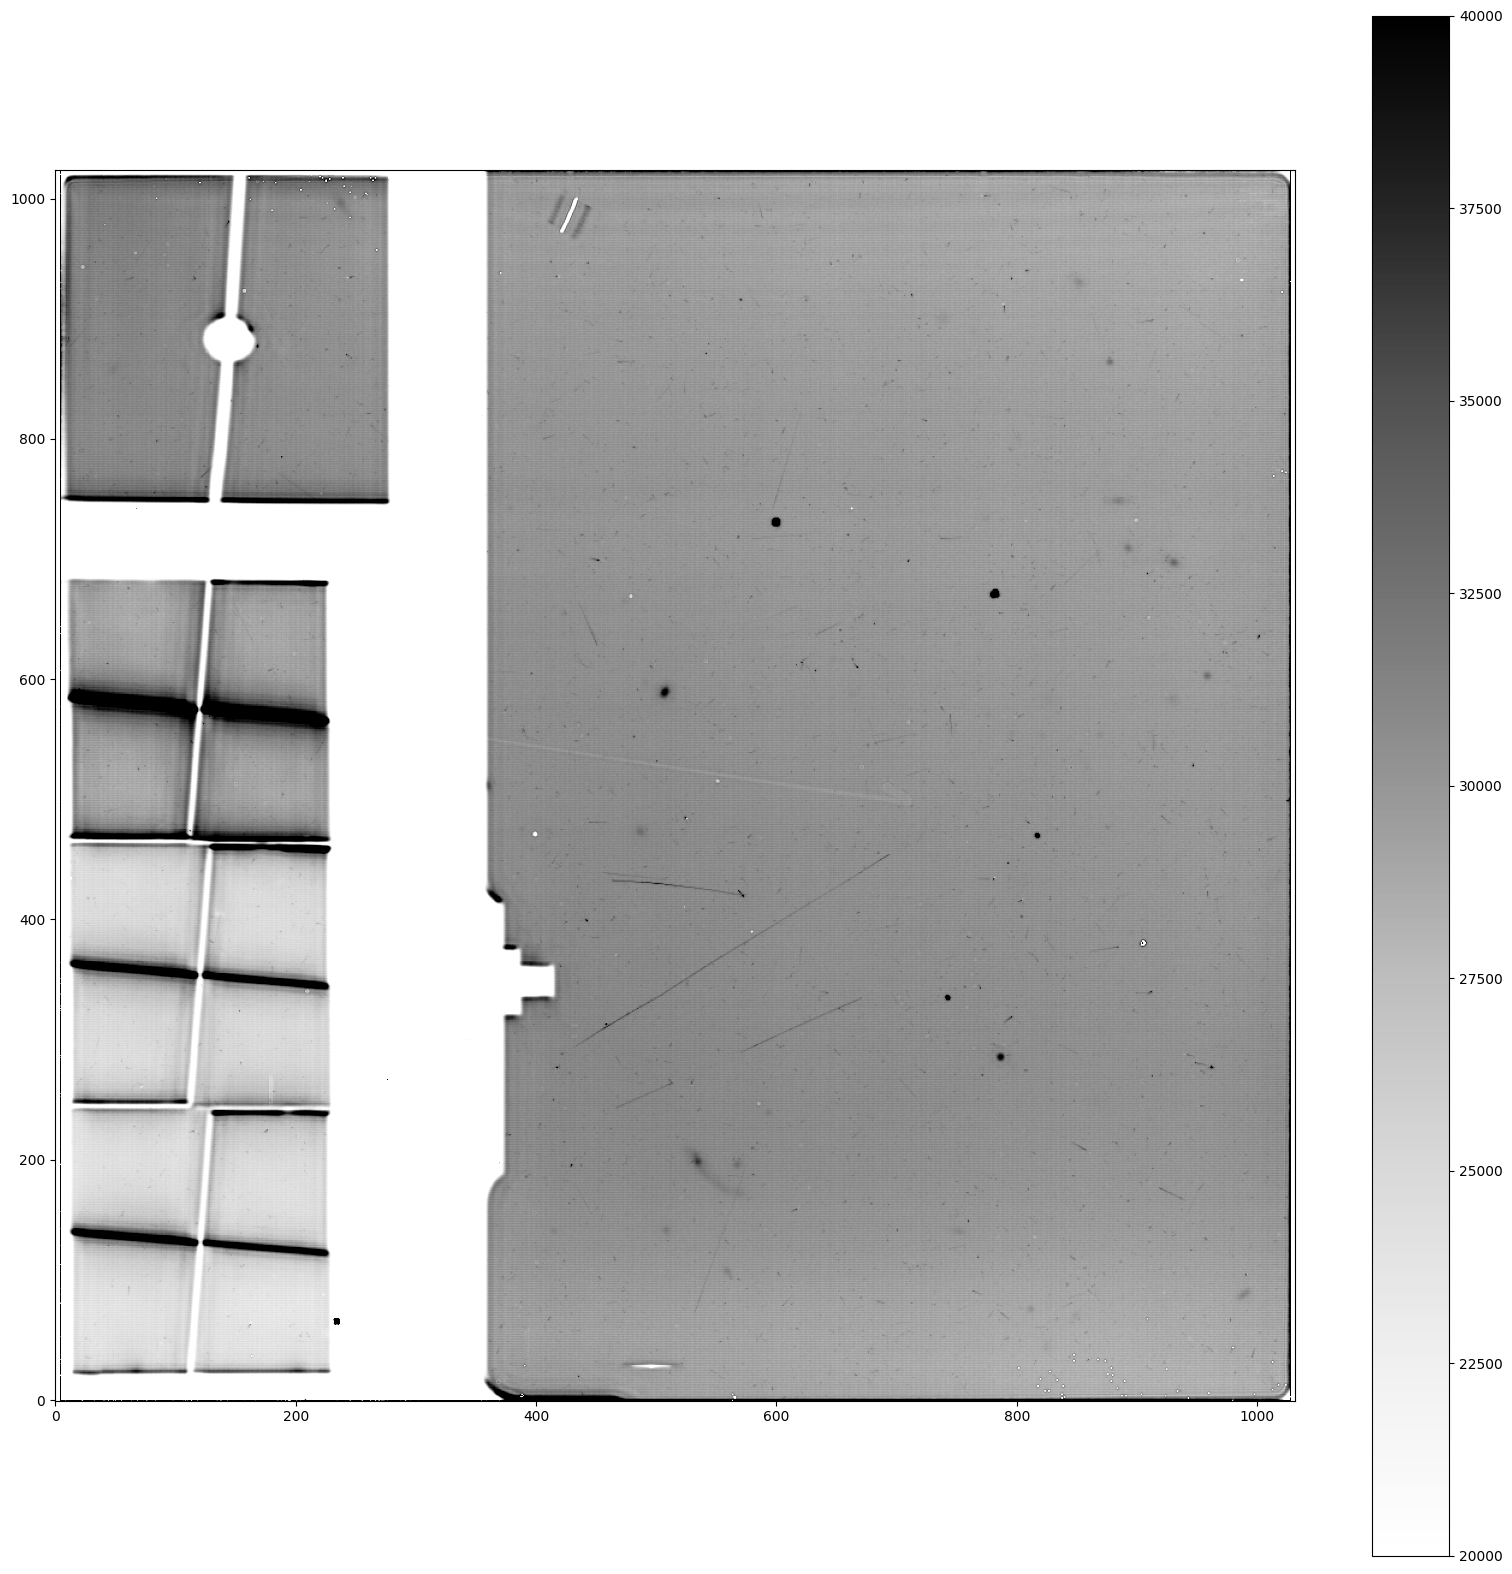

In [14]:
# Look at the last frame of one of the data files to visualize the field of view

plt.figure(figsize=(20,20))

plt.imshow(uncal_im.data[0, -1, :, :], cmap='Greys', origin='lower', vmin=20000,vmax=40000)
plt.colorbar()
plt.show()

## Run calwebb_detector1 on your data

Set a few parameters for the jump step (most steps are fine to run with defaults).
Loop through and run all files through calwebb_detector1 to get 'rate.fits' files that contain slope fit images.

When setting up the pipeline stage to run, using the .call() method requires setting up dictionaries for each of the steps that will have parameters set that are different from the defaults.

#### The detector1 pipeline will take the longest amount of runtime in this notebook. If you do not wish to process all of your data over from the start, you can download the cal.fits files from the archive, load those into the notebook, and run the background creation code from that point.

In [15]:
# Set a few Jump step parameters, for versions 1.10.0 and later (build version 9.2)
# find_showers turns the cr shower code on for MIRI. Set to False to skip this code. (Default is currently False.)
# Use mostly code defaults for the rest of the parameters.

rej_thresh = 5

expand_large_events = False  # This parameter is used for NIR instruments
find_showers = False  # This parameter is used for MIRI only

In [16]:
# Set a few parameters and run each file through the Detector1 Pipeline

for file in uncalfiles:
    pipe = Detector1Pipeline()
    
    # set up output file name
    base, remainder = file.split('_uncal')
    outname = base
    
    # Set up dictionaries for step parameters
    cfg = dict()
    cfg['jump'] = {}
    cfg['jump']['save_results'] = True # The jump output file is useful if you want to track which frames have jumps flagged
    cfg['jump']['rejection_threshold'] = rej_thresh
    cfg['jump']['expand_large_events'] = expand_large_events
    cfg['jump']['find_showers'] = find_showers
    cfg['jump']['output_file'] = base + '.fits'
    #cfg['jump']['output_dir'] = datadir

    #cfg['ramp_fit'] ={}
    #cfg['ramp_fit']['output_file'] = base + '.fits'
    #cfg['ramp_fit']['output_dir'] = datadir


    pipe.call(file, steps=cfg, save_results=True, output_file =  base + '.fits')

2023-07-14 16:58:12,269 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-07-14 16:58:12,270 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-07-14 16:58:12,271 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-07-14 16:58:12,273 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-07-14 16:58:12,274 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2023-07-14 16:58:12,275 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2023-07-14 16:58:12,277 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2023-07-14 16:58:12,279 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2023-07-14 16:58:12,280 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2023-07-14 16:58:12,281 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2023-07-14 1

2023-07-14 16:58:14,676 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00001_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-07-14 16:58:14,688 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-07-14 16:58:14,689 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-07-14 16:58:14,690 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_linearity_0039.fits'.
2023-07-14 16:58:14,690 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_m

2023-07-14 16:58:34,306 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits
2023-07-14 16:58:34,434 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 16:58:34,503 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 16:58:35,571 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-07-14 16:58:35,781 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00001_mirimage_uncal.fits>,).
2023-07-14 16:58:35,782 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_i

2023-07-14 17:00:36,466 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'signal_threshold': 30000.0}
2023-07-14 17:00:36,467 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step skipped.
2023-07-14 17:00:36,472 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction done
2023-07-14 17:00:36,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00001_mirimage_jump.fits>,).
2023-07-14 17:00:36,563 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output

2023-07-14 17:19:19,977 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-07-14 17:19:19,979 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-07-14 17:19:19,980 - stpipe.Detector1Pipeline.undersampling_correction - INFO - UndersamplingCorrectionStep instance created.
2023-07-14 17:19:19,981 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-07-14 17:19:19,983 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-07-14 17:19:20,095 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw02736002001_02105_00002_mirimage_uncal.fits',).
2023-07-14 17:19:20,108 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/science/WD_planets/scripts/jw02736002001_02105_00002_mirimage.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_us

2023-07-14 17:19:20,663 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-07-14 17:19:20,664 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-07-14 17:19:20,665 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits'.
2023-07-14 17:19:20,665 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_saturation_0034.fits'.
2023-07-14 17:19:20,666 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-07-14 17:19:20,666 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-07-14 17:19:20,666 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-07-14 17:19:20,667 - st

2023-07-14 17:19:41,747 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 17:19:44,639 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-07-14 17:19:44,815 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00002_mirimage_uncal.fits>,).
2023-07-14 17:19:44,816 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-07-14 17:19:44,851 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-07-14 17:19:45,797 - stpipe.D

2023-07-14 17:21:35,002 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits
2023-07-14 17:21:35,082 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2023-07-14 17:21:35,083 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2023-07-14 17:21:37,058 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1
2023-07-14 17:21:37,059 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2023-07-14 17:36:44,681 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 98
2023-07-14 17:36:44,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2023-07-14 17:36:46,618 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2023-07-14 17:36:46,819 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scal

2023-07-14 17:36:48,742 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00003_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-07-14 17:36:48,744 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-07-14 17:36:48,745 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-07-14 17:36:48,746 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_linearity_0039.fits'.
2023-07-14 17:36:48,747 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_m

2023-07-14 17:37:08,508 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits
2023-07-14 17:37:08,636 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 17:37:08,712 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 17:37:09,698 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-07-14 17:37:09,878 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00003_mirimage_uncal.fits>,).
2023-07-14 17:37:09,880 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_i

2023-07-14 17:39:02,825 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'signal_threshold': 30000.0}
2023-07-14 17:39:02,826 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step skipped.
2023-07-14 17:39:02,832 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction done
2023-07-14 17:39:02,928 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00003_mirimage_jump.fits>,).
2023-07-14 17:39:02,930 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output

2023-07-14 17:55:12,290 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-07-14 17:55:12,292 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-07-14 17:55:12,292 - stpipe.Detector1Pipeline.undersampling_correction - INFO - UndersamplingCorrectionStep instance created.
2023-07-14 17:55:12,293 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-07-14 17:55:12,295 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-07-14 17:55:12,413 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw02736002001_02105_00004_mirimage_uncal.fits',).
2023-07-14 17:55:12,426 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/science/WD_planets/scripts/jw02736002001_02105_00004_mirimage.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_us

2023-07-14 17:55:12,965 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-07-14 17:55:12,965 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-07-14 17:55:12,966 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits'.
2023-07-14 17:55:12,967 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_saturation_0034.fits'.
2023-07-14 17:55:12,967 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-07-14 17:55:12,968 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-07-14 17:55:12,968 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-07-14 17:55:12,969 - st

2023-07-14 17:55:33,910 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 17:55:36,446 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-07-14 17:55:36,624 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00004_mirimage_uncal.fits>,).
2023-07-14 17:55:36,626 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-07-14 17:55:36,659 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-07-14 17:55:37,609 - stpipe.D

2023-07-14 17:57:23,134 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits
2023-07-14 17:57:23,201 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2023-07-14 17:57:23,201 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2023-07-14 17:57:25,205 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1
2023-07-14 17:57:25,206 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2023-07-14 18:11:54,305 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 98
2023-07-14 18:11:54,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2023-07-14 18:11:56,244 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2023-07-14 18:11:56,455 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scal

2023-07-14 18:11:58,363 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00005_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-07-14 18:11:58,371 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-07-14 18:11:58,372 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-07-14 18:11:58,373 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_linearity_0039.fits'.
2023-07-14 18:11:58,373 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_m

2023-07-14 18:12:18,050 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits
2023-07-14 18:12:18,179 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 18:12:18,246 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 18:12:19,111 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-07-14 18:12:19,292 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00005_mirimage_uncal.fits>,).
2023-07-14 18:12:19,293 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_i

2023-07-14 18:14:13,382 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'signal_threshold': 30000.0}
2023-07-14 18:14:13,383 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step skipped.
2023-07-14 18:14:13,388 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction done
2023-07-14 18:14:13,483 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00005_mirimage_jump.fits>,).
2023-07-14 18:14:13,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output

2023-07-14 18:29:33,723 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-07-14 18:29:33,725 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-07-14 18:29:33,726 - stpipe.Detector1Pipeline.undersampling_correction - INFO - UndersamplingCorrectionStep instance created.
2023-07-14 18:29:33,727 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-07-14 18:29:33,729 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-07-14 18:29:33,849 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw02736002001_02105_00006_mirimage_uncal.fits',).
2023-07-14 18:29:33,862 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/science/WD_planets/scripts/jw02736002001_02105_00006_mirimage.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_us

2023-07-14 18:29:34,398 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-07-14 18:29:34,399 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-07-14 18:29:34,399 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits'.
2023-07-14 18:29:34,399 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_saturation_0034.fits'.
2023-07-14 18:29:34,400 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-07-14 18:29:34,400 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-07-14 18:29:34,401 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-07-14 18:29:34,402 - st

2023-07-14 18:29:55,771 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 18:29:58,534 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-07-14 18:29:58,718 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00006_mirimage_uncal.fits>,).
2023-07-14 18:29:58,720 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-07-14 18:29:58,754 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-07-14 18:29:59,681 - stpipe.D

2023-07-14 18:31:49,714 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits
2023-07-14 18:31:49,788 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2023-07-14 18:31:49,788 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2023-07-14 18:31:51,760 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1
2023-07-14 18:31:51,762 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2023-07-14 18:47:01,115 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 98
2023-07-14 18:47:01,115 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2023-07-14 18:47:03,084 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2023-07-14 18:47:03,277 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scal

2023-07-14 18:47:05,209 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00007_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-07-14 18:47:05,212 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-07-14 18:47:05,213 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-07-14 18:47:05,214 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_linearity_0039.fits'.
2023-07-14 18:47:05,215 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_m

2023-07-14 18:47:24,815 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits
2023-07-14 18:47:24,938 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 18:47:25,012 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 18:47:25,978 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-07-14 18:47:26,151 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00007_mirimage_uncal.fits>,).
2023-07-14 18:47:26,153 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_i

2023-07-14 18:49:16,699 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'signal_threshold': 30000.0}
2023-07-14 18:49:16,700 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step skipped.
2023-07-14 18:49:16,705 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction done
2023-07-14 18:49:16,801 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00007_mirimage_jump.fits>,).
2023-07-14 18:49:16,803 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output

2023-07-14 19:05:32,602 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-07-14 19:05:32,604 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-07-14 19:05:32,605 - stpipe.Detector1Pipeline.undersampling_correction - INFO - UndersamplingCorrectionStep instance created.
2023-07-14 19:05:32,606 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-07-14 19:05:32,608 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-07-14 19:05:32,726 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw02736002001_02105_00008_mirimage_uncal.fits',).
2023-07-14 19:05:32,740 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/science/WD_planets/scripts/jw02736002001_02105_00008_mirimage.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_us

2023-07-14 19:05:33,273 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-07-14 19:05:33,274 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-07-14 19:05:33,275 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits'.
2023-07-14 19:05:33,275 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_saturation_0034.fits'.
2023-07-14 19:05:33,276 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-07-14 19:05:33,276 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-07-14 19:05:33,277 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-07-14 19:05:33,278 - st

2023-07-14 19:05:54,669 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 19:05:57,354 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-07-14 19:05:57,533 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00008_mirimage_uncal.fits>,).
2023-07-14 19:05:57,535 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-07-14 19:05:57,568 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-07-14 19:05:58,522 - stpipe.D

2023-07-14 19:07:48,039 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits
2023-07-14 19:07:48,111 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2023-07-14 19:07:48,112 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2023-07-14 19:07:50,073 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1
2023-07-14 19:07:50,075 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2023-07-14 19:23:36,705 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 98
2023-07-14 19:23:36,706 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2023-07-14 19:23:38,519 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2023-07-14 19:23:38,725 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scal

2023-07-14 19:23:40,605 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00009_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-07-14 19:23:40,608 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-07-14 19:23:40,609 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-07-14 19:23:40,610 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_linearity_0039.fits'.
2023-07-14 19:23:40,611 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_m

2023-07-14 19:23:59,936 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits
2023-07-14 19:24:00,087 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 19:24:00,153 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 19:24:01,103 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-07-14 19:24:01,276 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00009_mirimage_uncal.fits>,).
2023-07-14 19:24:01,278 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_i

2023-07-14 19:25:49,586 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'signal_threshold': 30000.0}
2023-07-14 19:25:49,587 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step skipped.
2023-07-14 19:25:49,592 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction done
2023-07-14 19:25:49,694 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00009_mirimage_jump.fits>,).
2023-07-14 19:25:49,696 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output

2023-07-14 19:40:48,547 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-07-14 19:40:48,549 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-07-14 19:40:48,550 - stpipe.Detector1Pipeline.undersampling_correction - INFO - UndersamplingCorrectionStep instance created.
2023-07-14 19:40:48,551 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-07-14 19:40:48,553 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-07-14 19:40:48,671 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw02736002001_02105_00010_mirimage_uncal.fits',).
2023-07-14 19:40:48,684 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/science/WD_planets/scripts/jw02736002001_02105_00010_mirimage.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_us

2023-07-14 19:40:49,227 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-07-14 19:40:49,228 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-07-14 19:40:49,229 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits'.
2023-07-14 19:40:49,229 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_saturation_0034.fits'.
2023-07-14 19:40:49,230 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-07-14 19:40:49,230 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-07-14 19:40:49,231 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-07-14 19:40:49,232 - st

2023-07-14 19:41:10,323 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-07-14 19:41:13,084 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-07-14 19:41:13,266 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 100, 1024, 1032) from jw02736002001_02105_00010_mirimage_uncal.fits>,).
2023-07-14 19:41:13,268 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-07-14 19:41:13,301 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-07-14 19:41:14,237 - stpipe.D

2023-07-14 19:43:03,226 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_gain_0008.fits
2023-07-14 19:43:03,291 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2023-07-14 19:43:03,292 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2023-07-14 19:43:05,165 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1
2023-07-14 19:43:05,167 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2023-07-14 19:58:39,071 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 98
2023-07-14 19:58:39,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2023-07-14 19:58:40,956 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2023-07-14 19:58:41,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scal

#### Look at output rate image

Plot one of the output rate images to see what the image looks like. The code here will also mark any pixels with a DQ value of DO_NOT_USE in blue. These blue pixels are considered bad in some way and will not contribute to the final combined image.

In [17]:
# Load and look at a single rate image
  
ratefiles = [ele.replace('uncal', 'rate') for ele in uncalfiles]
rate_im = ImageModel(ratefiles[0])

2023-07-14 19:58:41,871 - stpipe - WARNING - /var/folders/qq/59kq_9pn42d5fg_5wxzzwx1w0004_p/T/ipykernel_78605/351219847.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
2023-07-14 19:58:41,872 - stpipe - WARNING -   cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
2023-07-14 19:58:41,872 - stpipe - WARNING - 


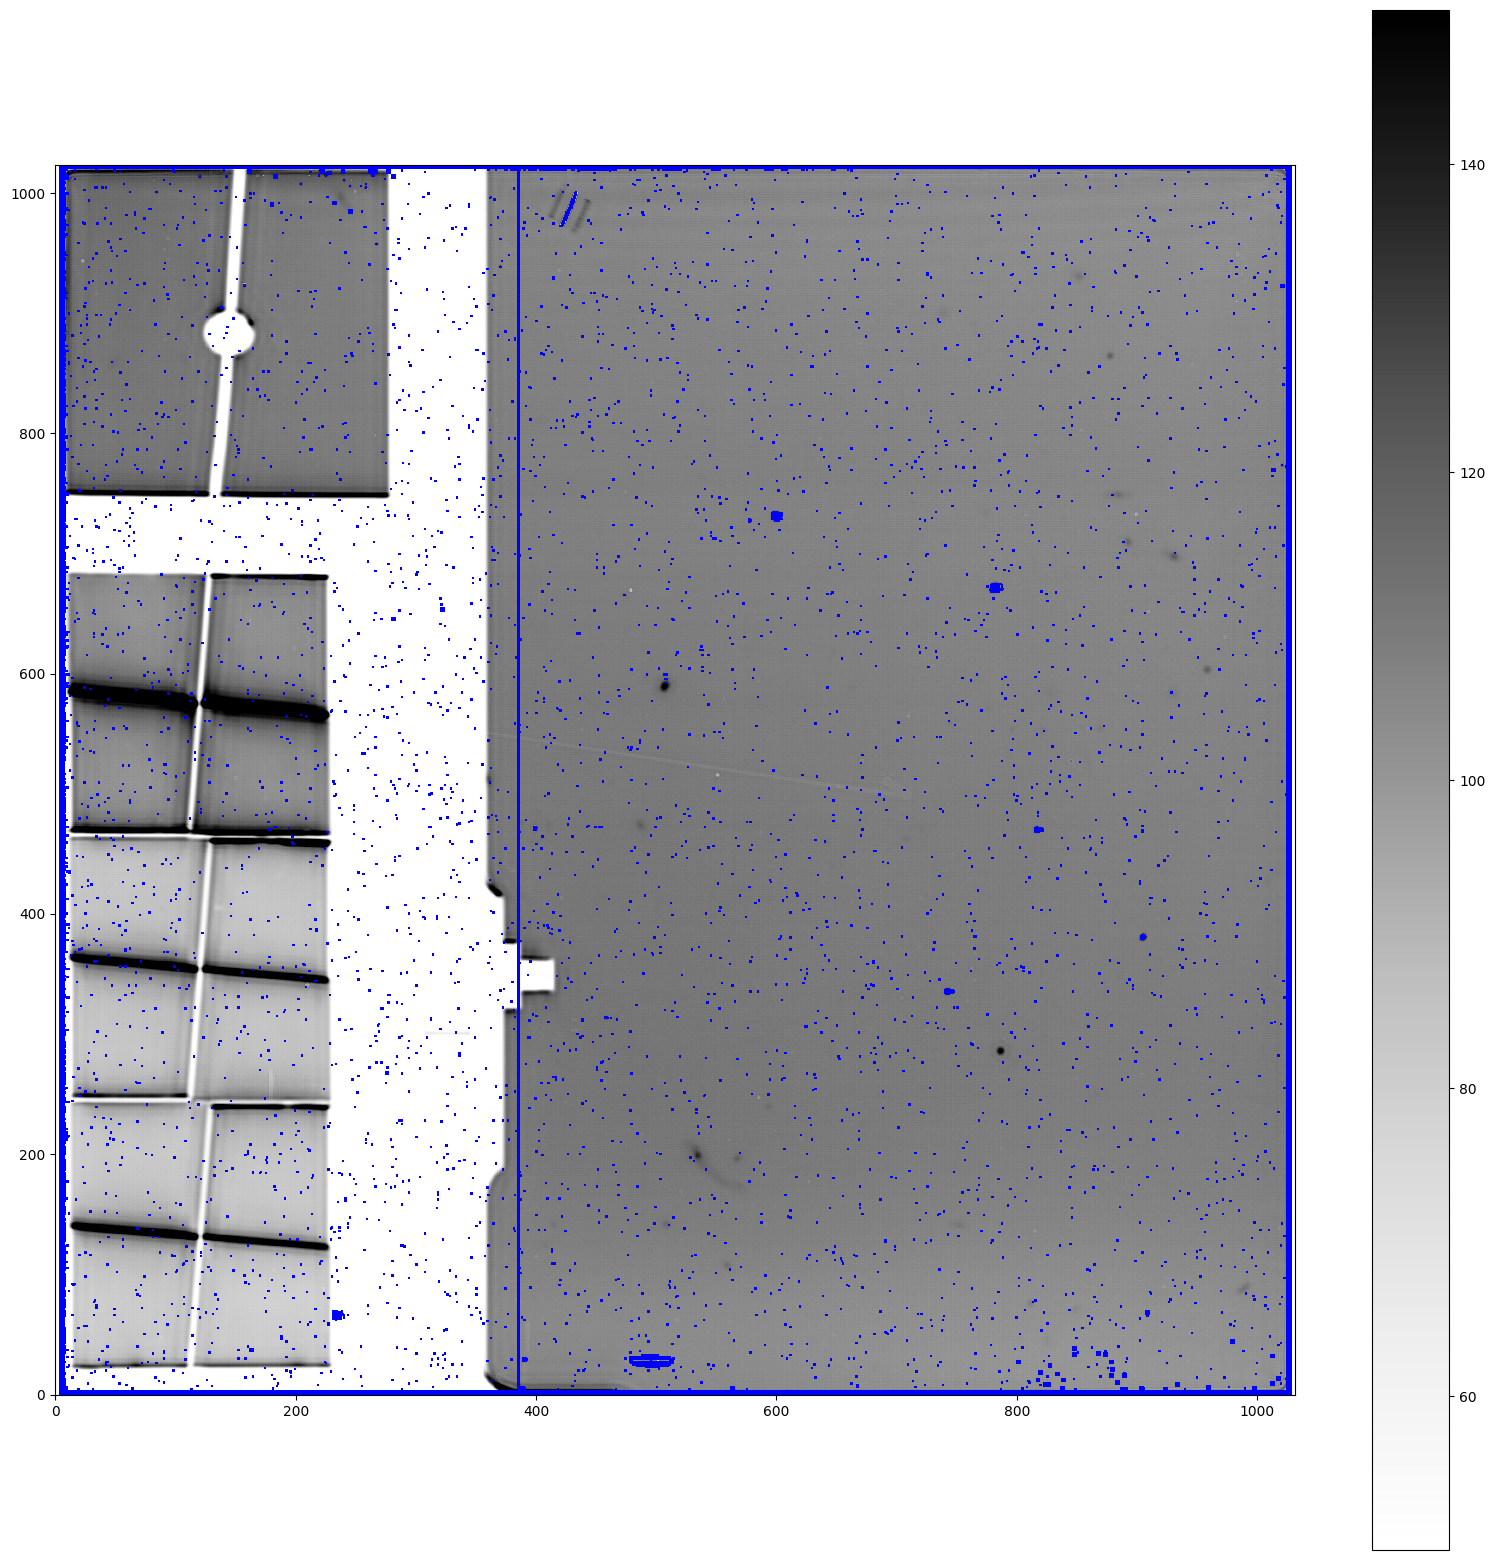

In [18]:
# Look at the averaged slope image, and plot the DO_NOT_USE dq flagged pixels in blue

plt.figure(figsize=(20,20))

# mask out DO_NOT_USE values of 1
masked_rate_im = np.ma.masked_where((rate_im.dq & dqflags.pixel['DO_NOT_USE'] > 0), rate_im.data)

cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='blue') # color to mark all DO_NOT_USE pixels

plt.imshow(masked_rate_im, cmap=cmap, origin='lower', vmin=50,vmax=150.0)
plt.colorbar()
plt.show()

## Run calwebb_detector2

Run the output of detector1 (rate files) through calwebb_detector2 to obtain a set of calibrated files (cal files).


In [19]:
# Run Calwebb_image2 on output files from detector1    
    
print('There are ', len(ratefiles), ' images.')
    
callist = []

# cycle through files
for im in ratefiles:

    calfile = Image2Pipeline.call(im, save_results=True)

    callist.append(calfile)

print(callist)

2023-07-14 19:58:42,874 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2023-07-14 19:58:42,876 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-07-14 19:58:42,877 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-07-14 19:58:42,878 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2023-07-14 19:58:42,879 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2023-07-14 19:58:42,881 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2023-07-14 19:58:42,965 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('jw02736002001_02105_00001_mirimage_rate.fits',).
2023-07-14 19:58:42,971 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'sk

There are  10  images.


2023-07-14 19:58:43,045 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00001_mirimage_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2023-07-14 19:58:43,058 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_area_0004.fits'.
2023-07-14 19:58:43,059 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-07-14 19:58:43,059 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-07-14 19:58:43,060 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-07-14 19:58:43,060 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2023-07-

2023-07-14 19:58:44,287 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2023-07-14 19:58:44,383 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw02736002001_02105_00001_mirimage_rate.fits>,).
2023-07-14 19:58:44,385 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'output_wcs': '', 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}
2023-07-14 19:58:44,426 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /U

2023-07-14 19:58:47,911 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2023-07-14 19:58:47,911 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2023-07-14 19:58:47,912 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2023-07-14 19:58:47,912 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2023-07-14 19:58:47,913 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2023-07-14 19:58:47,913 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2023-07-14 19:58:47,913 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2023-07-14 19:58:47,914 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_photom_0074.fits'.
2023-07-14 19:58:47,914 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2023-07-14 1

2023-07-14 19:58:50,339 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:58:50,577 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2023-07-14 19:58:50,963 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:58:51,197 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2023-07-14 19:58:51,580 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:58:51,860 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  110.737293164 -73.447518765 110.777859395 -73.476713313 110.881432940 -73.465017303 110.840717136 -73.435842794
2023-07-14 19:58:52,103 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw02736002001_02105_00002_mirimage_i2d.fits
2023-07-14 19:58:52,104 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2023-07-14 19:58:52,108 - stpipe.Image2Pipeline - INFO - Finished processing product j

2023-07-14 19:58:52,819 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2023-07-14 19:58:53,050 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'ms

2023-07-14 19:58:57,168 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2023-07-14 19:58:57,268 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('jw02736002001_02105_00004_mirimage_rate.fits',).
2023-07-14 19:58:57,274 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_

2023-07-14 19:58:57,982 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2023-07-14 19:58:58,076 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_flat_0793.fits
2023-07-14 19:58:58,077 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT
2023-07-14 19:58:58,077 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT
2023-07-14 19:58:58,077 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT
2023-07-14 19:58:58,210 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
20

2023-07-14 19:59:02,148 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00005_mirimage_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2023-07-14 19:59:02,152 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_area_0004.fits'.
2023-07-14 19:59:02,153 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-07-14 19:59:02,153 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-07-14 19:59:02,154 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-07-14 19:59:02,154 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2023-07-

2023-07-14 19:59:03,312 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2023-07-14 19:59:03,416 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw02736002001_02105_00005_mirimage_rate.fits>,).
2023-07-14 19:59:03,418 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'output_wcs': '', 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}
2023-07-14 19:59:03,456 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /U

2023-07-14 19:59:06,946 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2023-07-14 19:59:06,946 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2023-07-14 19:59:06,946 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2023-07-14 19:59:06,947 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2023-07-14 19:59:06,947 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2023-07-14 19:59:06,948 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2023-07-14 19:59:06,948 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2023-07-14 19:59:06,948 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_photom_0074.fits'.
2023-07-14 19:59:06,949 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2023-07-14 1

2023-07-14 19:59:09,387 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:09,622 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2023-07-14 19:59:10,007 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:10,244 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2023-07-14 19:59:10,628 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:10,901 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  110.735826109 -73.446787809 110.776387852 -73.475982666 110.879958051 -73.464287447 110.839246741 -73.435112627
2023-07-14 19:59:11,121 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw02736002001_02105_00006_mirimage_i2d.fits
2023-07-14 19:59:11,122 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2023-07-14 19:59:11,124 - stpipe.Image2Pipeline - INFO - Finished processing product j

2023-07-14 19:59:11,859 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2023-07-14 19:59:12,086 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'ms

2023-07-14 19:59:16,285 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2023-07-14 19:59:16,392 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('jw02736002001_02105_00008_mirimage_rate.fits',).
2023-07-14 19:59:16,399 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_

2023-07-14 19:59:17,138 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2023-07-14 19:59:17,237 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_flat_0793.fits
2023-07-14 19:59:17,238 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT
2023-07-14 19:59:17,238 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT
2023-07-14 19:59:17,239 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT
2023-07-14 19:59:17,358 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
20

2023-07-14 19:59:21,260 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736002001_02105_00009_mirimage_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2023-07-14 19:59:21,263 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_area_0004.fits'.
2023-07-14 19:59:21,264 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-07-14 19:59:21,265 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-07-14 19:59:21,265 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-07-14 19:59:21,266 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2023-07-

2023-07-14 19:59:22,445 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2023-07-14 19:59:22,556 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw02736002001_02105_00009_mirimage_rate.fits>,).
2023-07-14 19:59:22,559 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'output_wcs': '', 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}
2023-07-14 19:59:22,597 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /U

2023-07-14 19:59:26,053 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2023-07-14 19:59:26,054 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2023-07-14 19:59:26,054 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2023-07-14 19:59:26,055 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2023-07-14 19:59:26,055 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2023-07-14 19:59:26,055 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2023-07-14 19:59:26,056 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2023-07-14 19:59:26,056 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_photom_0074.fits'.
2023-07-14 19:59:26,057 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2023-07-14 1

2023-07-14 19:59:28,543 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:28,785 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2023-07-14 19:59:29,176 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:29,406 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2023-07-14 19:59:29,788 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2023-07-14 19:59:30,052 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  110.742672605 -73.446639247 110.783245833 -73.475832770 110.886810359 -73.464134148 110.846087600 -73.434960666
2023-07-14 19:59:30,278 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw02736002001_02105_00010_mirimage_i2d.fits
2023-07-14 19:59:30,278 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2023-07-14 19:59:30,281 - stpipe.Image2Pipeline - INFO - Finished processing product j

[[<ImageModel(1024, 1032) from jw02736002001_02105_00001_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00002_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00003_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00004_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00005_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00006_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00007_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00008_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00009_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw02736002001_02105_00010_mirimage_cal.fits>]]


## Create and subtract mean sky background image

The input for the following steps is the list of calibrated files that were the result of calwebb_image2 processing. These files will be used to create the mean (or median) background image. Once the background image is created, it will be subtracted from each of the individual cal files, creating a set of background subtracted calibrated files. These files can then be processed through the last stage of the pipeline, calwebb_image3, to combine the background subtracted files into a dither combined mosaic image.

In [20]:
# Set the filter being used in the data, so that it can be used in output file names.

filter = 'F1500W' 

In [21]:
# Gather the list of cal files for the sky subtraction steps.

#miri_cal_files = glob.glob('*cal.fits') # this will collect all cal files in the directory

miri_cal_files = [ele.replace('rate', 'cal') for ele in ratefiles]

print(miri_cal_files)

['jw02736002001_02105_00001_mirimage_cal.fits', 'jw02736002001_02105_00002_mirimage_cal.fits', 'jw02736002001_02105_00003_mirimage_cal.fits', 'jw02736002001_02105_00004_mirimage_cal.fits', 'jw02736002001_02105_00005_mirimage_cal.fits', 'jw02736002001_02105_00006_mirimage_cal.fits', 'jw02736002001_02105_00007_mirimage_cal.fits', 'jw02736002001_02105_00008_mirimage_cal.fits', 'jw02736002001_02105_00009_mirimage_cal.fits', 'jw02736002001_02105_00010_mirimage_cal.fits']


In [22]:
# Use the script make_sky to make and subtract off the sky background image.

simage = make_sky(miri_cal_files, scalebkg=scalebkg,
                  ds9regions=ds9region, exclude_above=exclude_above, exclude_delta=exclude_delta)

processing jw02736002001_02105_00001_mirimage_cal.fits
median sky = 39.341712951660156
processing jw02736002001_02105_00002_mirimage_cal.fits
median sky = 39.40052795410156
processing jw02736002001_02105_00003_mirimage_cal.fits
median sky = 39.400665283203125
processing jw02736002001_02105_00004_mirimage_cal.fits
median sky = 39.39704895019531
processing jw02736002001_02105_00005_mirimage_cal.fits
median sky = 39.38936996459961
processing jw02736002001_02105_00006_mirimage_cal.fits
median sky = 39.38581466674805
processing jw02736002001_02105_00007_mirimage_cal.fits
median sky = 39.38115310668945
processing jw02736002001_02105_00008_mirimage_cal.fits
median sky = 39.37928009033203
processing jw02736002001_02105_00009_mirimage_cal.fits
median sky = 39.368011474609375
processing jw02736002001_02105_00010_mirimage_cal.fits


2023-07-14 19:59:32,596 - stpipe - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:364: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
2023-07-14 19:59:32,596 - stpipe - WARNING -   warnings.warn(
2023-07-14 19:59:32,597 - stpipe - WARNING - 


median sky = 39.366371154785156
Not scaling individual images to median bkg


2023-07-14 19:59:33,120 - stpipe - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1027: RuntimeWarning: Mean of empty slice
2023-07-14 19:59:33,121 - stpipe - WARNING -   mean = np.nanmean(data_clipped, axis=axis)
2023-07-14 19:59:33,121 - stpipe - WARNING - 
2023-07-14 19:59:33,616 - stpipe - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1028: RuntimeWarning: All-NaN slice encountered
2023-07-14 19:59:33,617 - stpipe - WARNING -   median = np.nanmedian(data_clipped, axis=axis)
2023-07-14 19:59:33,617 - stpipe - WARNING - 
2023-07-14 19:59:33,844 - stpipe - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
2023-07-14 19:59:33,844 - stpipe - WARNING -   var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
2023-07-14 19:59:33,845 - stp

jw02736002001_02105_00001_mirimage_cal.fits
jw02736002001_02105_00002_mirimage_cal.fits
jw02736002001_02105_00003_mirimage_cal.fits
jw02736002001_02105_00004_mirimage_cal.fits
jw02736002001_02105_00005_mirimage_cal.fits
jw02736002001_02105_00006_mirimage_cal.fits
jw02736002001_02105_00007_mirimage_cal.fits
jw02736002001_02105_00008_mirimage_cal.fits
jw02736002001_02105_00009_mirimage_cal.fits
jw02736002001_02105_00010_mirimage_cal.fits


### Look at a sample image before and after sky subtraction

Also look at the mean sky image itself and write it out.

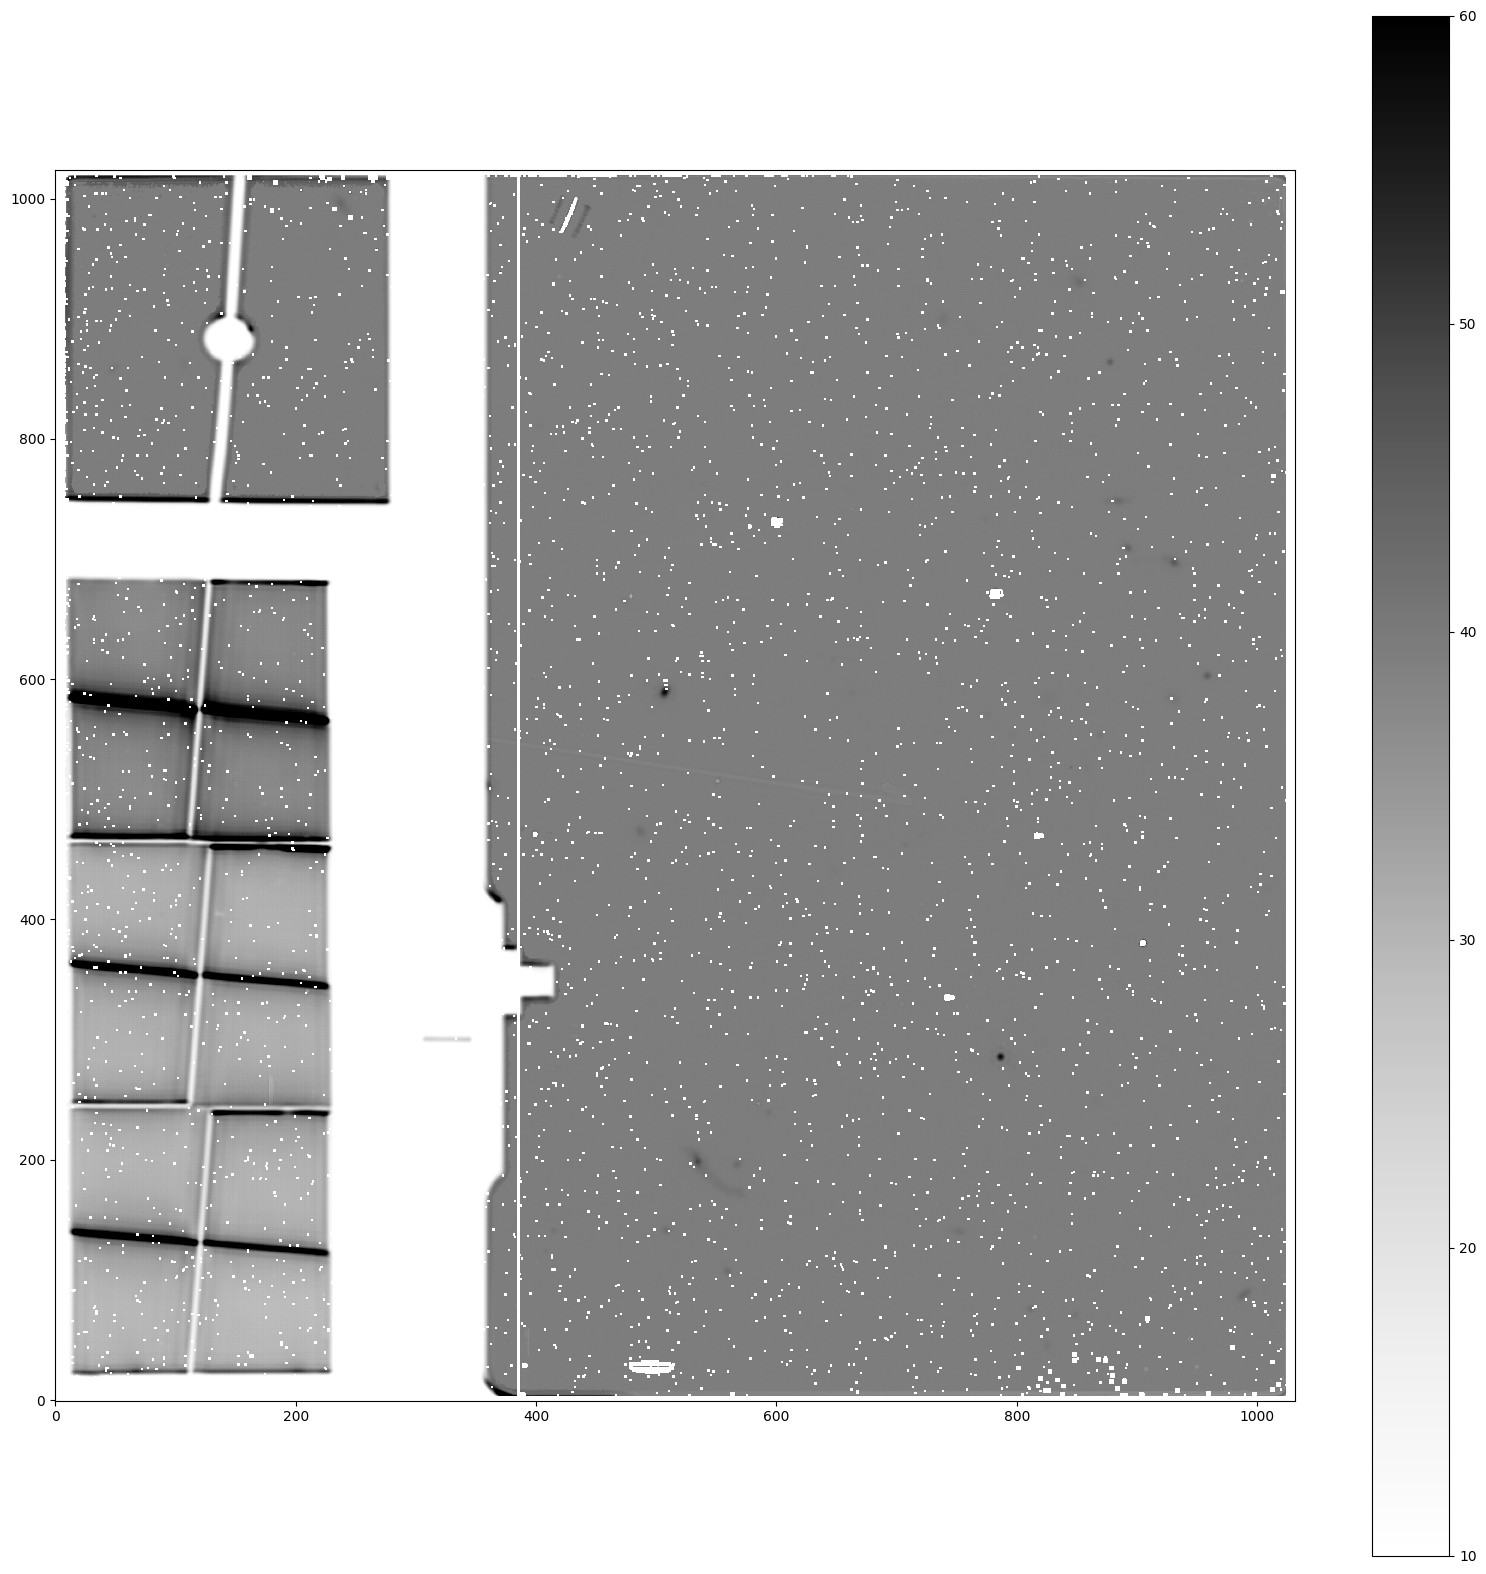

In [23]:
# Look at cal image before sky subtraction

im = ImageModel(miri_cal_files[0])

plt.figure(figsize=(20,20))
plt.imshow(im.data, cmap='Greys', origin='lower', vmin=10,vmax=60)
plt.colorbar()
plt.show()

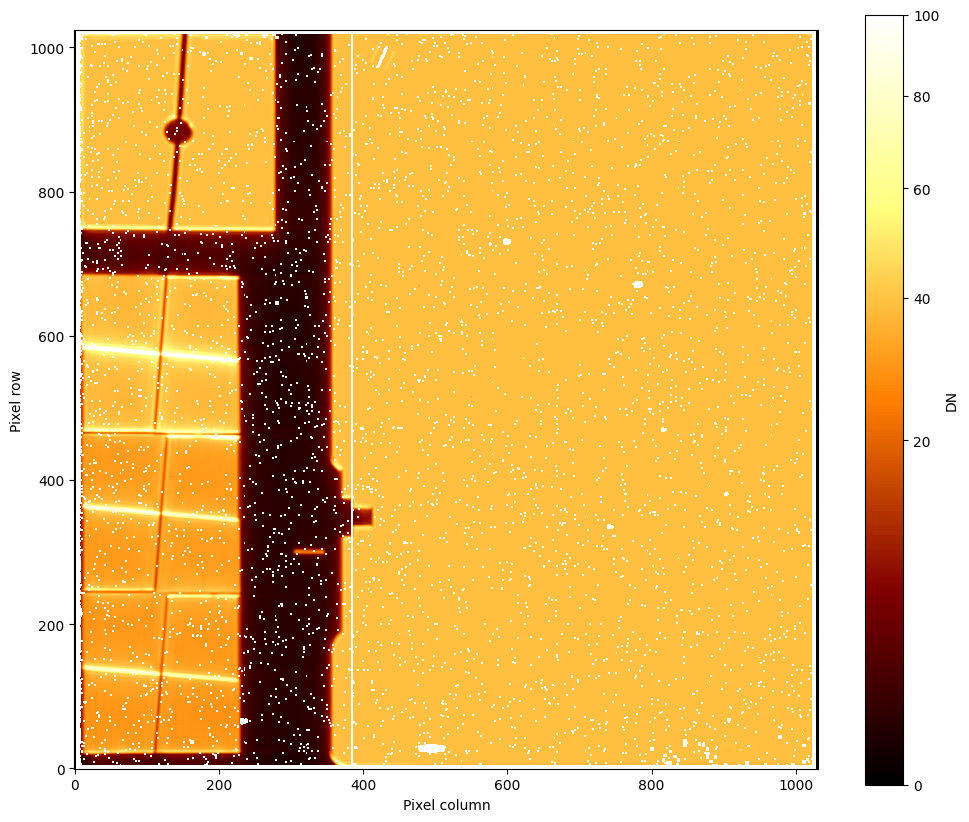

In [24]:
# Look at the created median sky image and write to a file

drange_cal = [0., 100.]
show_image(simage, drange_cal[0], drange_cal[1], dmap=dmap)
fits.writeto(filter+'_sky.fits', simage, overwrite=True)

In [25]:
# Gather sky subtracted cal files
miri_skysub_files = glob.glob('*skysub_cal.fits')

miri_skysub_files = [ele.replace('cal', 'skysub_cal') for ele in miri_cal_files]


print(miri_skysub_files)

['jw02736002001_02105_00001_mirimage_skysub_cal.fits', 'jw02736002001_02105_00002_mirimage_skysub_cal.fits', 'jw02736002001_02105_00003_mirimage_skysub_cal.fits', 'jw02736002001_02105_00004_mirimage_skysub_cal.fits', 'jw02736002001_02105_00005_mirimage_skysub_cal.fits', 'jw02736002001_02105_00006_mirimage_skysub_cal.fits', 'jw02736002001_02105_00007_mirimage_skysub_cal.fits', 'jw02736002001_02105_00008_mirimage_skysub_cal.fits', 'jw02736002001_02105_00009_mirimage_skysub_cal.fits', 'jw02736002001_02105_00010_mirimage_skysub_cal.fits']


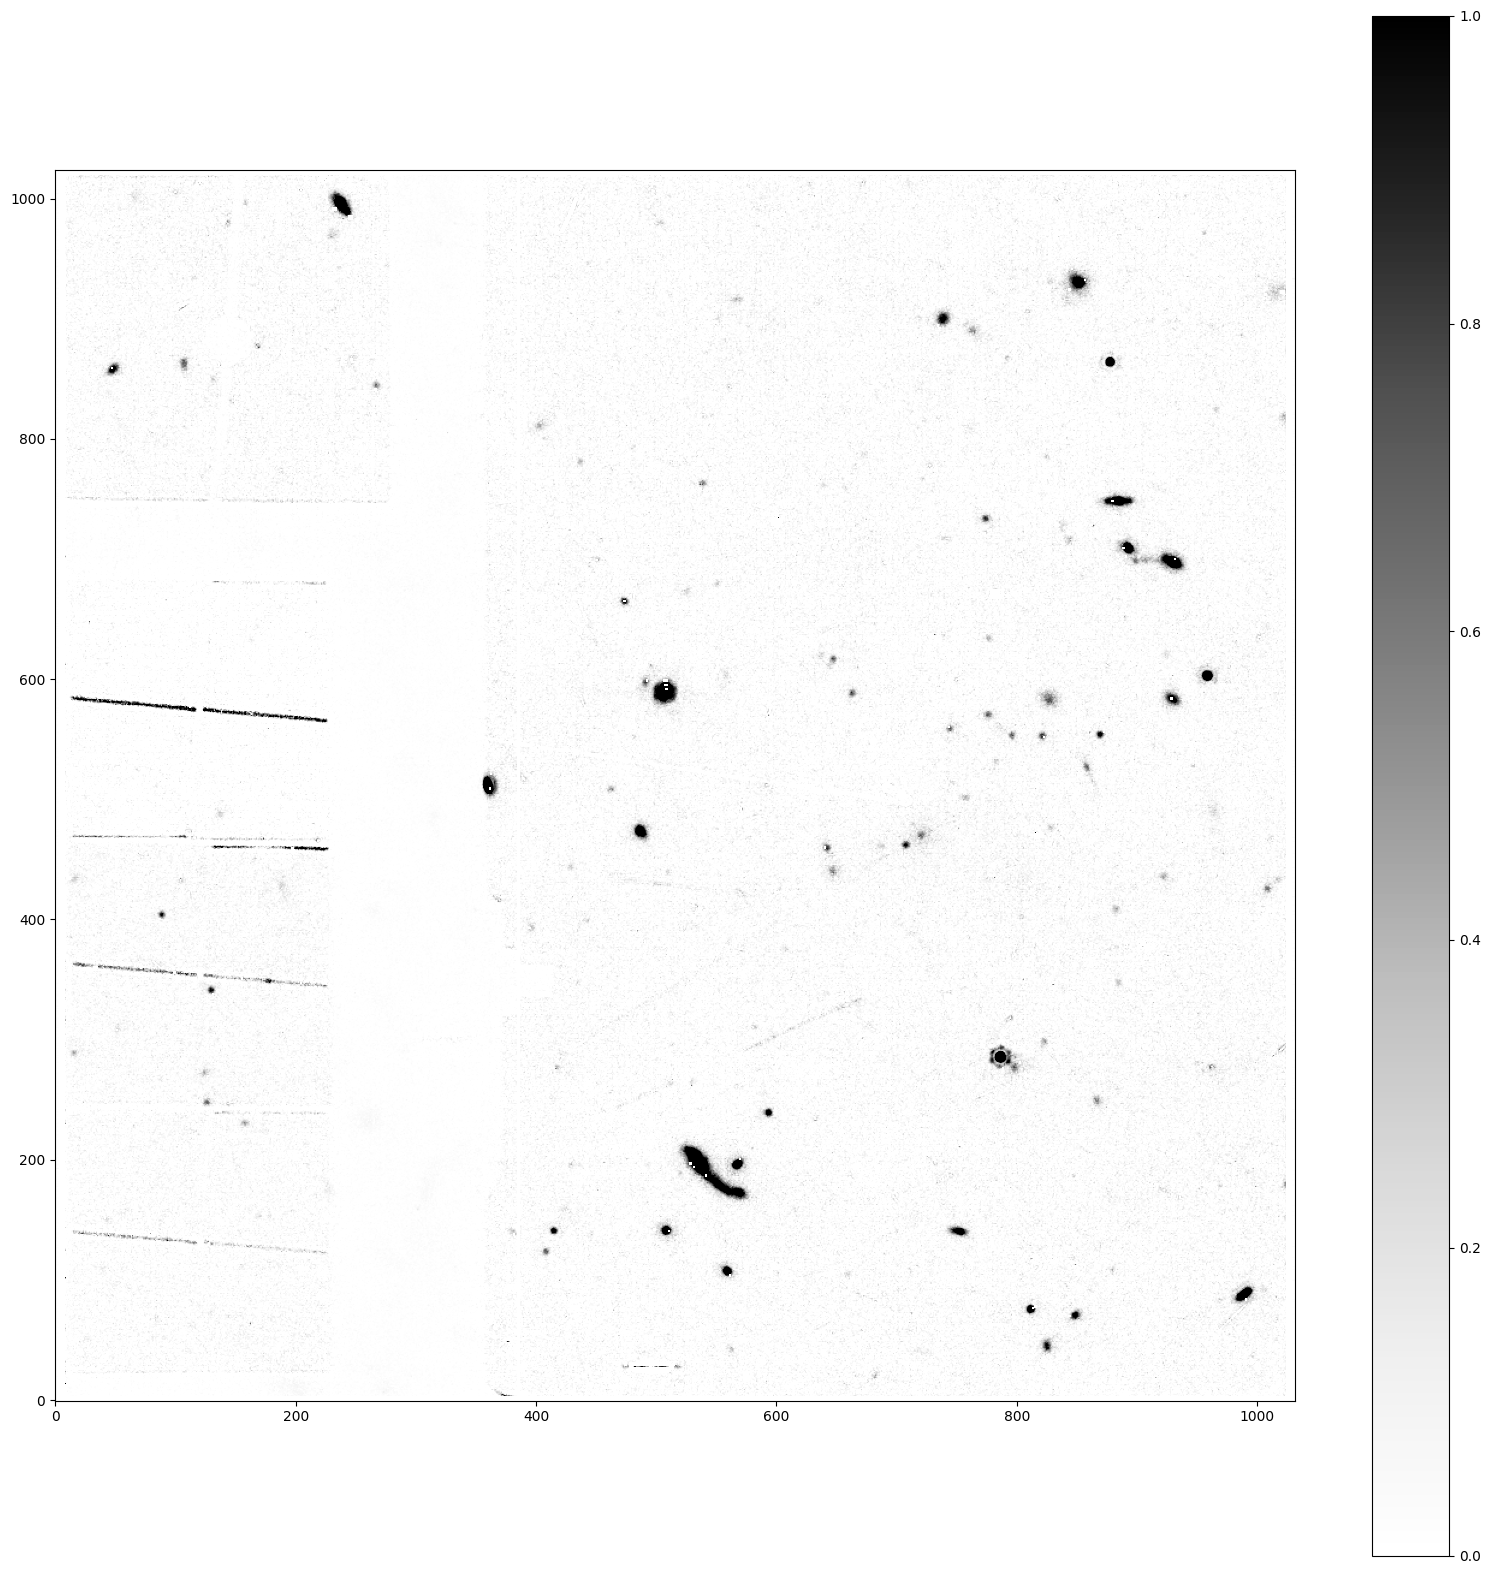

In [26]:
# Look at cal image after sky subtraction

im2 = ImageModel(miri_skysub_files[0])

plt.figure(figsize=(20,20))
plt.imshow(im2.data, cmap='Greys', origin='lower', vmin=0,vmax=1)
plt.colorbar()
plt.show()

### Run Calwebb_image3 on background subtracted cal files

First create a new association file for the background subtracted files, and then use that file to process the set through calwebb_image3.


In [28]:
# use asn_from_list to create association table
miri_asn_name = 'miri_'+filter+'_stage3_asn_skysub' # name of output asn file

asn = asn_from_list.asn_from_list(miri_skysub_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

# dump association table to a .json file for use in image3

miri_asn_file = miri_asn_name+'.json'
with open(miri_asn_file, 'w') as outfile:
    outfile.write(asn.dump()[1])

In [29]:
# Run calwebb_image3 (or Image3Pipeline) on sky subtracted data using association table.

cfg = dict() 

#cfg['tweakreg'] = {}
#cfg['tweakreg']['abs_refcat'] = 'GAIADR2'
#cfg['skymatch'] = {'skip' : True} 

cfg['resample']={}  # set up empty dictionary for multiple parameters to be set per step
cfg['resample']['rotation'] = rotation
cfg['resample']['kernel'] = 'gaussian'

cfg['outlier_detection'] = {'save_intermediate_results' : True}  # Can set single parameters with this syntax
                     
output = Image3Pipeline.call(miri_asn_file, steps=cfg, save_results=True)

2023-07-14 19:59:41,321 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_pars-tweakregstep_0014.asdf
2023-07-14 19:59:41,333 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0049.asdf
2023-07-14 19:59:41,347 - stpipe - INFO - PARS-SOURCECATALOGSTEP parameters found: /Users/cracraft/crds_cache_ops/references/jwst/miri/jwst_miri_pars-sourcecatalogstep_0013.asdf
2023-07-14 19:59:41,363 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2023-07-14 19:59:41,364 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-07-14 19:59:41,366 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2023-07-14 19:59:41,368 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2023-07-14 19:59:41,369 - stpipe.Image3Pipeline.outlier_detection - INFO - Outlier

2023-07-14 19:59:44,205 - stpipe.Image3Pipeline.tweakreg - WARNING - 
2023-07-14 19:59:44,637 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 19 sources in jw02736002001_02105_00002_mirimage_skysub_cal.fits.
2023-07-14 19:59:44,650 - stpipe.Image3Pipeline.tweakreg - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/photutils/background/background_2d.py:274: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
2023-07-14 19:59:44,650 - stpipe.Image3Pipeline.tweakreg - WARNING -   warnings.warn('Input data contains invalid values (NaNs or '
2023-07-14 19:59:44,651 - stpipe.Image3Pipeline.tweakreg - WARNING - 
2023-07-14 19:59:45,081 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 15 sources in jw02736002001_02105_00003_mirimage_skysub_cal.fits.
2023-07-14 19:59:45,094 - stpipe.Image3Pipeline.tweakreg - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/photutils/backgro

2023-07-14 19:59:48,432 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.8.2
2023-07-14 19:59:48,433 - stpipe.Image3Pipeline.tweakreg - INFO -  
2023-07-14 19:59:48,659 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: jw02736002001_02105_00001_mirimage_skysub_cal' as reference image
2023-07-14 19:59:48,664 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw02736002001_02105_00002_mirimage_skysub_cal' to the reference catalog.
2023-07-14 19:59:48,768 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw02736002001_02105_00002_mirimage_skysub_cal' catalog with sources from the reference 'jw02736002001_02105_00001_mirimage_skysub_cal' catalog.
2023-07-14 19:59:48,768 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2023-07-14 19:59:48,770 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.1215, 0.1091 (arcsec) with significance of 8 and 9 matches.
2023-07-14

2023-07-14 19:59:49,753 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2023-07-14 19:59:49,755 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: jw02736002001_02105_00007_mirimage_skysub_cal:
2023-07-14 19:59:49,756 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.0263557  YSH: -0.0793145
2023-07-14 19:59:49,756 - stpipe.Image3Pipeline.tweakreg - INFO - 
2023-07-14 19:59:49,757 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.239475   FIT MAE: 0.157137
2023-07-14 19:59:49,757 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 11 objects.
2023-07-14 19:59:49,794 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw02736002001_02105_00008_mirimage_skysub_cal' to the reference catalog.
2023-07-14 19:59:49,906 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw02736002001_02105_00008_mirimage_skysub_cal' catalog with sources from the reference 'jw02736002001_02105_00001_mirimage_skysub

2023-07-14 19:59:50,980 - stpipe.Image3Pipeline.tweakreg - WARNING - 
2023-07-14 19:59:51,067 - stpipe.Image3Pipeline.tweakreg - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/gwcs/wcs.py:2943: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
2023-07-14 19:59:51,068 - stpipe.Image3Pipeline.tweakreg - WARNING -   warnings.warn(fit_warning_msg, linalg.LinAlgWarning)
2023-07-14 19:59:51,068 - stpipe.Image3Pipeline.tweakreg - WARNING - 
2023-07-14 19:59:51,157 - stpipe.Image3Pipeline.tweakreg - WARNING - /Users/cracraft/miniconda3/envs/jwst_v1111/lib/python3.11/site-packages/gwcs/wcs.py:2943: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
2023-07-14 19:59:51,157 - stpipe.Image3Pipeline.tweakreg - WARNING -   warnings.warn(fit_warning_msg, linalg.LinAlgWarning)
2023-07-14 19:59:51,158 - stpipe.Image3Pipeline.tweakreg - WARNING - 
2023-07-14 19:59:51,182 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg do

2023-07-14 20:00:21,538 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure jw02736002001_02105_00006_mirimage_skysub_outlier_i2d.fits saved to file
2023-07-14 20:00:21,547 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together
2023-07-14 20:00:22,053 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:22,430 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure jw02736002001_02105_00007_mirimage_skysub_outlier_i2d.fits saved to file
2023-07-14 20:00:22,440 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together
2023-07-14 20:00:22,957 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:23,342 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure jw02736002001_02105_00008_mirimage_skysub_outlier_i2d.fits saved to file
2023-07-14 20:00:23,354 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposure

2023-07-14 20:00:55,575 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:56,213 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:56,351 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise
2023-07-14 20:00:56,747 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:57,390 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:58,076 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:58,755 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:00:59,447 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:01:00,112 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1146, 1116)
2023-07-14 20:01:00,770 - stpipe.Image3Pipeline.resample - INFO 

#### Look at the output combined mosaic and overlay the source catalog to see what sources were found

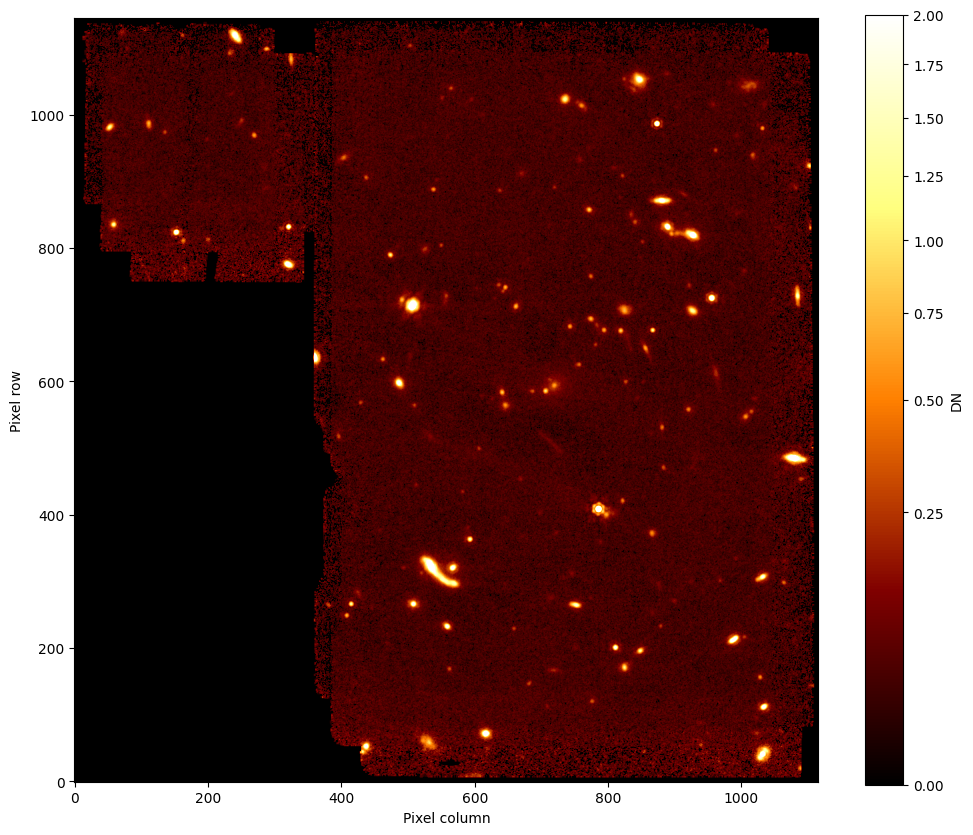

In [30]:
# Look at the resulting mosaic image
miri_mosaic_file =  miri_asn_name + '_i2d.fits'
miri_mosaic = datamodels.open(miri_mosaic_file)
drange = drange_cal
drange_ssub = [0,2]

# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange_ssub[0], vmax=drange_ssub[1], dmap=dmap)

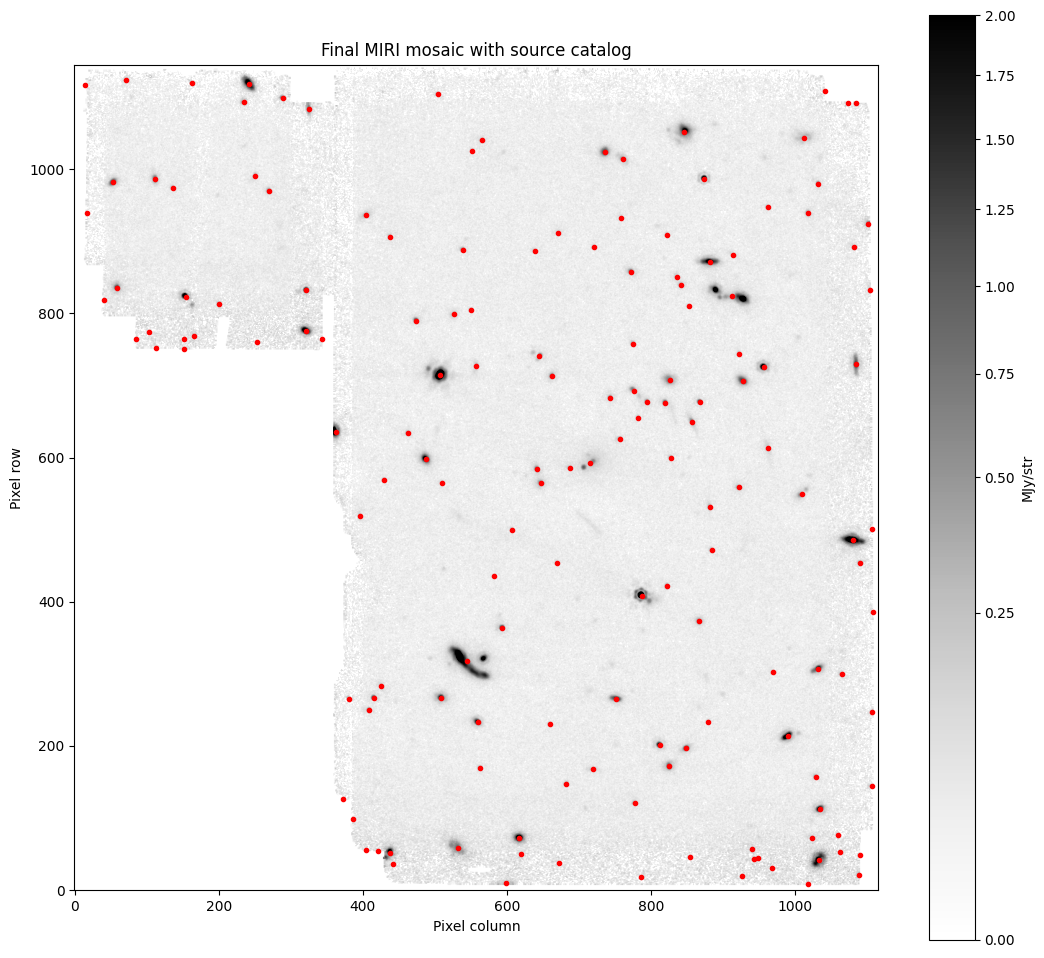

In [31]:
# Look at mosaic data and sources found with source_catalog

miri_catalog_file = miri_asn_name + '_cat.ecsv'

# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=drange_ssub[0], vmax=drange_ssub[1],
                title='Final MIRI mosaic with source catalog', dmap="Greys")